### Using LSTM and training on word embeddings. The results were no where near as good, so I stopped working on this, with 0.67 on the validation set.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

In [3]:
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack

In [4]:
train = pd.read_csv("../datasets/preprocessed_train.csv")
test = pd.read_csv("../datasets/preprocessed_test.csv")
train.head()

,Comment,Outcome,Id,num_numbers,prop_numbers,num_words,num_punctuation,prop_punctuation,nchar,word_density,pos_tags,noun_count,verb_count,adj_count,adv_count,pron_count,lda
0,from the constants section of the r language d...,1,32216,21,0.033926,114,18,0.029079,619,5.382609,"[('from', 'IN'), ('the', 'DT'), ('constants', ...",37,17,9,5,4,NaN
1,"when you run ""knit html"", the code is trying t...",1,37915,0,0.000000,104,42,0.069767,602,5.733333,"[('when', 'WRB'), ('you', 'PRP'), ('run', 'VBP...",29,21,7,7,5,NaN
2,"the preferred way, when applicable: for r in r...",1,36837,0,0.000000,127,57,0.077551,735,5.742188,"[('the', 'DT'), ('preferred', 'JJ'), ('way', '...",46,17,12,11,5,NaN
3,an r list can have named elements and so funct...,1,38240,4,0.007220,98,23,0.041516,554,5.595960,"[('an', 'DT'), ('r', 'JJ'), ('list', 'NN'), ('...",30,14,10,5,4,NaN
4,a geom_ribbon is exactly what you need ggplot(...,1,36239,1,0.003984,30,56,0.223108,251,8.096774,"[('a', 'DT'), ('geom_ribbon', 'NN'), ('is', 'V...",22,2,11,1,2,NaN


In [5]:
from sklearn import metrics

In [6]:
stop_words = set(stopwords.words("english"))
def preprocess(text):
    text = "".join([i.lower() if not i.isdigit() and i not in string.punctuation else " " for i in text])
    text = word_tokenize(text)
    text = [word for word in text if len(word) > 2 and word not in stop_words]
    return " ".join(text)

In [7]:
train["Comment"] = train["Comment"].apply(lambda x: preprocess(x))
test["Comment"] = test["Comment"].apply(lambda x: preprocess(x))

In [8]:
from tqdm import tqdm
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['Comment']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [9]:
corpus=create_corpus_new(train)

100%|██████████| 44459/44459 [00:37<00:00, 1174.68it/s]


In [10]:
embedding_dict={}
with open('glove.6B.100d.txt','r', encoding="utf8") as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [12]:
MAX_LEN=100
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

train_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [13]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 69916


In [14]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec 

100%|██████████| 69916/69916 [00:00<00:00, 266105.89it/s]


In [15]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

In [16]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          6991700   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 7,072,201
Trainable params: 80,501
Non-trainable params: 6,991,700
_________________________________________________________________


In [18]:
train_corpus=train_pad[:train.shape[0]]
test_corpus=train_pad[train.shape[0]:]

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(train_corpus,train['Outcome'].values,test_size=0.2, random_state=0)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (35567, 100)
Shape of Validation  (8892, 100)


In [20]:
history=model.fit(X_train,y_train,batch_size=16,epochs=60,validation_data=(X_val,y_val),verbose=2)

Train on 35567 samples, validate on 8892 samples
Epoch 1/60
 - 174s - loss: 0.6652 - accuracy: 0.5717 - val_loss: 0.6572 - val_accuracy: 0.5855
Epoch 2/60
 - 177s - loss: 0.6567 - accuracy: 0.5980 - val_loss: 0.6450 - val_accuracy: 0.6217
Epoch 3/60
 - 174s - loss: 0.6517 - accuracy: 0.6045 - val_loss: 0.6406 - val_accuracy: 0.6273
Epoch 4/60
 - 174s - loss: 0.6444 - accuracy: 0.6181 - val_loss: 0.6359 - val_accuracy: 0.6312
Epoch 5/60
 - 179s - loss: 0.6417 - accuracy: 0.6247 - val_loss: 0.6338 - val_accuracy: 0.6356
Epoch 6/60
 - 172s - loss: 0.6378 - accuracy: 0.6281 - val_loss: 0.6321 - val_accuracy: 0.6282
Epoch 7/60
 - 175s - loss: 0.6344 - accuracy: 0.6294 - val_loss: 0.6385 - val_accuracy: 0.6278
Epoch 8/60
 - 173s - loss: 0.6307 - accuracy: 0.6374 - val_loss: 0.6315 - val_accuracy: 0.6120
Epoch 9/60
 - 173s - loss: 0.6284 - accuracy: 0.6387 - val_loss: 0.6183 - val_accuracy: 0.6564
Epoch 10/60
 - 173s - loss: 0.6241 - accuracy: 0.6426 - val_loss: 0.6162 - val_accuracy: 0.6565


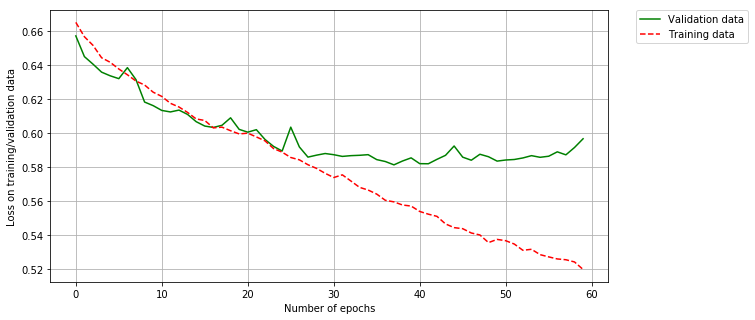

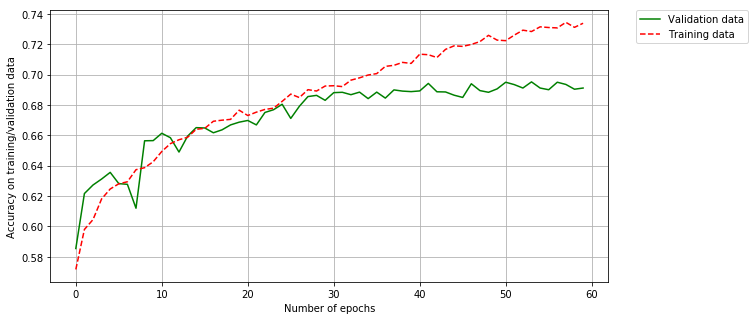

In [21]:
from __future__ import division
import numpy as np

# Plot loss and accuracy 
fig = plt.figure(figsize=(10,5))

#plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['val_loss'], 'g-', label='Validation data')
plt.plot(history.epoch, history.history['loss'], 'r--', label='Training data')
plt.grid(True)
plt.xlabel('Number of epochs')
plt.ylabel('Loss on training/validation data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#plt.subplot(1, 2, 2)
fig = plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['val_accuracy'], 'g-', label='Validation data')
plt.plot(history.epoch, history.history['accuracy'], 'r--', label='Training data')
plt.grid(True)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on training/validation data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Validation accuracy tapers off, but doesn't decrease with an increase in epochs.

In [22]:
from sklearn import metrics

In [23]:
train_pred_GloVe = model.predict(X_train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')
print("Accuracy: ", metrics.accuracy_score(y_train, train_pred_GloVe_int))
print("Auroc: ", metrics.roc_auc_score(y_train, train_pred_GloVe_int))

val_pred_GloVe = model.predict(X_val)
val_pred_GloVe_int = val_pred_GloVe.round().astype('int')
print("Accuracy: ", metrics.accuracy_score(y_val, val_pred_GloVe_int))
print("Auroc: ", metrics.roc_auc_score(y_val, val_pred_GloVe_int))

Accuracy:  0.7817921106643799
Auroc:  0.7684356884796075
Accuracy:  0.691183085919928
Auroc:  0.673574900629066


In [24]:
corpus=create_corpus_new(test)
MAX_LEN=100
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

100%|██████████| 27924/27924 [00:23<00:00, 1177.04it/s]


In [25]:
test_pred_GloVe = model.predict(test_pad)
test_pred_GloVe_int = test_pred_GloVe.round().astype('int')

### Although I should have left it without using astype int for AUC score, there score was too much worse to justify using this model

In [26]:
test["Outcome"] = test_pred_GloVe_int

In [27]:
test[["Id", "Outcome"]].to_csv("submission.csv", index=False)